In [1]:
%matplotlib inline
import numpy
import pandas
import theano
import theano.tensor as T
import matplotlib.pyplot as plt


import os, sys
sys.path.append('../code')

from retina2 import *

/home/oalenkin/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_csv('../data/hits.csv', index_col=0)

# Stations 1&2

In [4]:
from combination import Combinator
from metrics import TracksReconstractionMetrics, CombinatorQuality

In [5]:
array_of_initial_parameters = []
#for i in np.linspace(-50, 50, 5):
#    for j in np.linspace(-100, 100, 5):
#        array_of_initial_parameters.append([j, 0, i, 0])
#array_of_initial_parameters = np.array(array_of_initial_parameters)

for j in np.linspace(-100, 100, 5):
    array_of_initial_parameters.append([j, 0, 0, 0])
array_of_initial_parameters = np.array(array_of_initial_parameters)

#array_of_initial_parameters = np.array([[0, 0, 0, 0]])

In [15]:
%%time
event_ids = numpy.unique(data.EventID.values)

tracks12 = {}
tracks34 = {}
tracks_comb = {}

tracks_metrics_before_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

tracks_metrics_after_all = pandas.DataFrame(columns=['EventID', 'AvgEff', 'RecoEff', 'GhostRate', 'CloneRate'])

combinations = pandas.DataFrame(columns=['EventID', 'TrackIDBefore', 'TrackIDAfter', 'Charge', 'PInv'])
combinations_true = pandas.DataFrame(columns=['EventID', 'IsTrueCombination', 'PdgCode', 'Charge', 
                                                 'IsTrueCharge', 'TruePInv', 'PErr', 'Label'])

combinations_quality = pandas.DataFrame(columns=['EventID', 'RecoEff', 'GhostRate', 'CloneRate', 'NCombined'])

pass_stages = pandas.DataFrame(columns=['RecoEvents', 'Y12', 'Y34', 'Combination', 'Matching'])

for event_id in event_ids:
    
    # Get an event
    event = data[data.EventID == event_id]
    event12 = event[(event.StatNb == 1) + (event.StatNb == 2)]
    event34 = event[(event.StatNb == 3) + (event.StatNb == 4)]
    
    # Tracks reconstruction before the magnet
    tr2d12 = RetinaTrackReconstruction(sigma_from=100., sigma_to=1, eps=0.05, y_scale=1.)
    tr2d12.fit(event12[['Wx1', 'Wy1', 'Wz', 'Wx2', 'Wy2', 'Wz']].values, array_of_initial_parameters)
    
    labels12 = tr2d12.labels_
    tracks_params12 = tr2d12.tracks_params_
    
    # Quality metrics of the reconstruction
    trm12 = TracksReconstractionMetrics(0.2)
    trm12.fit(labels12, event12)
    
    tracks_metrics_before_all.loc[len(tracks_metrics_before_all)] = [event_id, 
                                                                 trm12.avg_efficiency_, 
                                                                 trm12.recognition_efficiency_, 
                                                                 trm12.ghost_rate_, 
                                                                 trm12.clone_rate_]

    # Tracks reconstruction after the magnet
    tr2d34 = RetinaTrackReconstruction(sigma_from=100., sigma_to=1, eps=0.05, y_scale=1.)
    tr2d34.fit(event34[['Wx1', 'Wy1', 'Wz', 'Wx2', 'Wy2', 'Wz']].values, array_of_initial_parameters)
    
    labels34 = tr2d34.labels_
    tracks_params34 = tr2d34.tracks_params_
    
    # Quality metrics of the reconstruction
    trm34 = TracksReconstractionMetrics(0.2)
    trm34.fit(labels34, event34)
    
    tracks_metrics_after_all.loc[len(tracks_metrics_after_all)] = [event_id, 
                                                                 trm34.avg_efficiency_, 
                                                                 trm34.recognition_efficiency_, 
                                                                 trm34.ghost_rate_, 
                                                                 trm34.clone_rate_]
    
    
    # Save the reconstructed tracks
    tracks12[event_id] = {'labels':labels12, 'params':tracks_params12}
    tracks34[event_id] = {'labels':labels34, 'params':tracks_params34}
    
    
    # Combination of the tracks before and after the magnet
    comb = Combinator()
    comb.combine(tracks_params12, tracks_params34)
    
    for num in range(len(comb.tracks_combinations_)):
        
        combinations.loc[len(combinations)] = [event_id, 
                                               comb.tracks_combinations_[num][0], 
                                               comb.tracks_combinations_[num][1], 
                                               comb.charges_[num], 
                                               comb.inv_momentums_[num]]
    
    # Quality of the combination
    cq = CombinatorQuality()
    cq.fit(labels12, labels34, comb.tracks_combinations_, comb.charges_, comb.inv_momentums_, event12, event34)
    
    combinations_quality.loc[len(combinations_quality)] = [event_id, 
                                                           cq.reco_eff_, 
                                                           cq.ghost_rate_, 
                                                           cq.clone_rate_, 
                                                           cq.n_combined_]
    
    for num in range(len(cq.check_tracks_combinations_)):
        
        combinations_true.loc[len(combinations_quality)] = [event_id, 
                                                               cq.check_tracks_combinations_[num], 
                                                               cq.true_pdg_codes_[num], 
                                                               cq.true_charges_[num],
                                                               cq.check_charges_[num], 
                                                               cq.true_inv_momentums_[num], 
                                                               cq.momentums_err_[num],
                                                               cq.labels_[num]]

    
    
    # Overall quality
    pass_stages.loc[len(pass_stages)] = numpy.array([1, 
                                                     (trm12.recognition_efficiency_ == 1)*1,
                                                     (trm34.recognition_efficiency_ == 1)*1, 
                                                     (cq.n_combined_ >= 2)*1,
                                                     (cq.reco_eff_ == 1)*1]).cumprod()
    
    # Save the tracks combination
    tracks_comb[event_id] = {'tracks_combinations':comb.tracks_combinations_, 
                             'charges':comb.charges_, 
                             'inv_momentums':comb.inv_momentums_}
    
    print event_id

2
7
10
15
23
27
39
48
50
53
62
74
84
85
86
94
97
102
106
122
126
129
131
134
135
143
157
159
161
174
179
184
189
211
215
221
249
257
270
276
289
292
294
299
331
341
365
369
370
377
381
406
407
408
412
417
426
445
449
484
490
500
502
513
515
516
518
549
558
565
606
608
612
614
622
625
642
644
648
651
654
670
686
692
694
707
712
715
719
735
736
747
759
767
768
777
781
782
785
791
793
806
809
813
824
828
839
842
845
856
876
878
883
885
893
897
901
916
917
923
927
928
933
953
957
968
970
978
1006
1008
1009
1011
1021
1023
1036
1042
1057
1066
1086
1090
1111
1116
1129
1136
1138
1142
1153
1156
1157
1180
1190
1200
1204
1213
1222
1224
1232
1235
1238
1242
1251
1256
1262
1265
1279
1280
1283
1284
1286
1293
1299
1311
1322
1329
1339
1340
1349
1352
1359
1360
1369
1375
1377
1380
1381
1383
1385
1410
1423
1427
1439
1440
1441
1451
1458
1474
1494
1528
1533
1541
1546
1548
1550
1557
1598
1600
1606
1607
1617
1629
1637
1655
1668
1675
1677
1683
1691
1693
1704
1717
1722
1724
1747
1756
1758
1761
1762
1769
1775
17

UnboundLocalError: local variable 'track2' referenced before assignment

# Quality

# Stations 1&2

## track efficiency

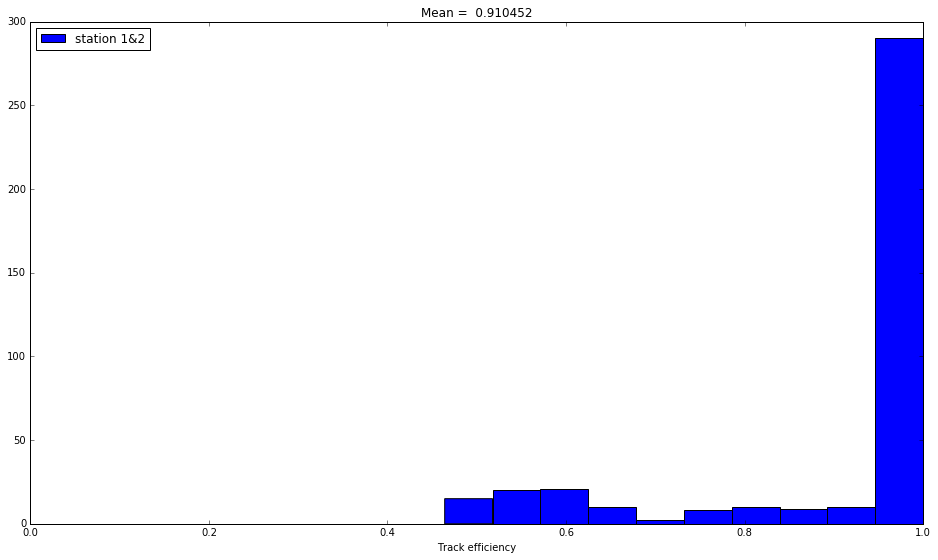

In [16]:
plt.figure(figsize=(16, 9))

eff_station = tracks_metrics_before_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

## reconstruction efficiency

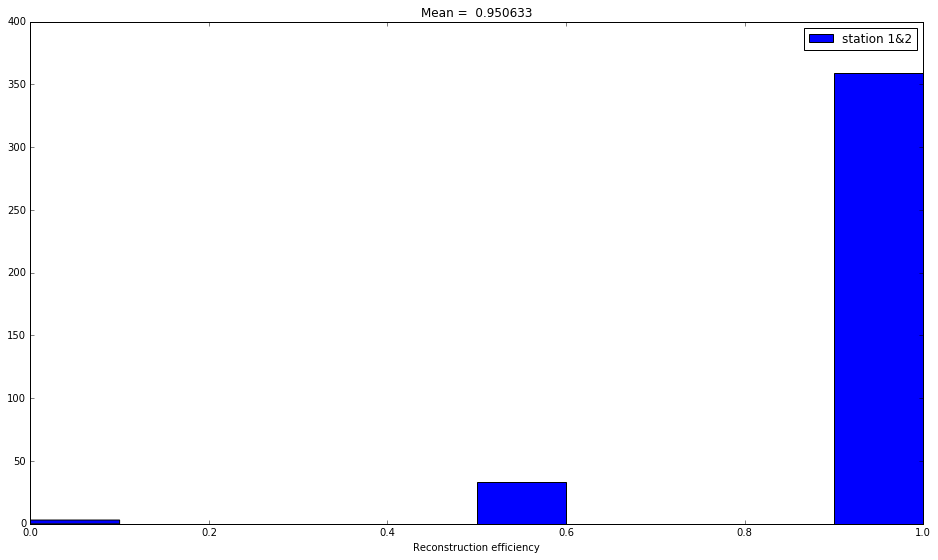

In [17]:
plt.figure(figsize=(16, 9))

eff_station = tracks_metrics_before_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 1&2')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Stations 3&4

## track efficiency

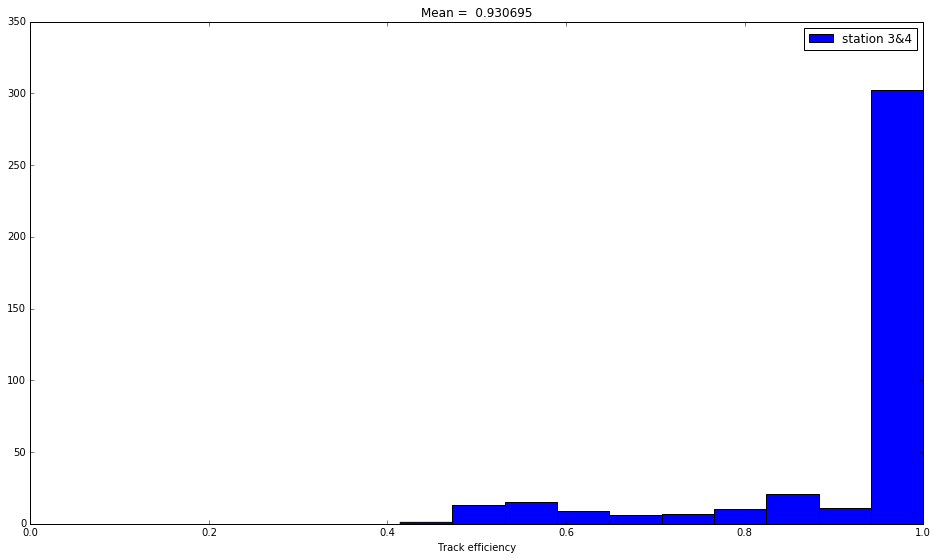

In [18]:
plt.figure(figsize=(16, 9))

eff_station = tracks_metrics_after_all.AvgEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Track efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

## reconstruction efficiency

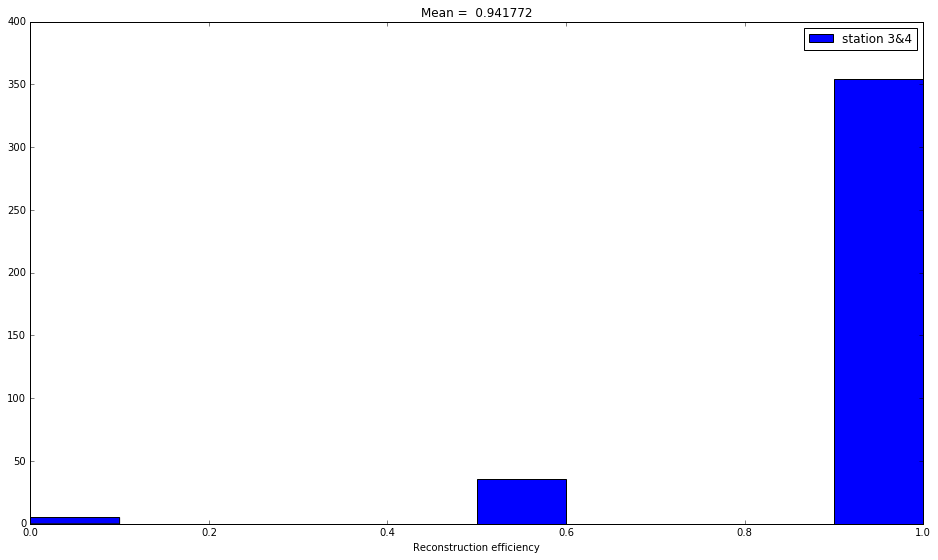

In [19]:
plt.figure(figsize=(16, 9))

eff_station = tracks_metrics_after_all.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff_station).mean())
plt.hist(eff_station, label='station 3&4')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.show()

# Combination

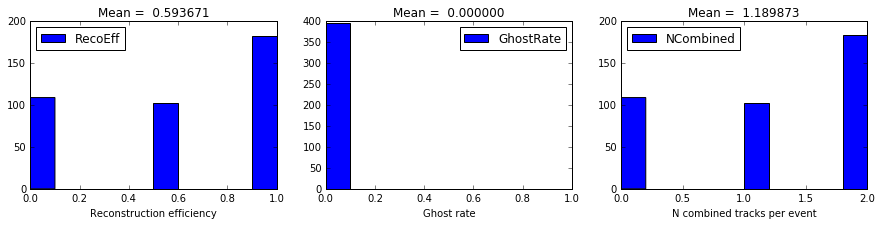

In [20]:
plt.figure(figsize=(15, 3))

plt.subplot(1,3,1)
eff = combinations_quality.RecoEff.values
plt.title('Mean = % f' % numpy.array(eff).mean())
plt.hist(eff, label='RecoEff')
plt.xlabel('Reconstruction efficiency')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,2)
ghost = combinations_quality.GhostRate.values
plt.title('Mean = % f' % numpy.array(ghost).mean())
plt.hist(ghost, label='GhostRate')
plt.xlabel('Ghost rate')
plt.xlim(0, 1)
plt.legend(loc='best')

plt.subplot(1,3,3)
n_combined = combinations_quality.NCombined.values
plt.title('Mean = % f' % numpy.array(n_combined).mean())
plt.hist(n_combined, label='NCombined')
plt.xlabel('N combined tracks per event')
plt.xlim(0, 2)
plt.legend(loc='best')

plt.show()

# Ratio of the events passes through the stages

46.3291139241


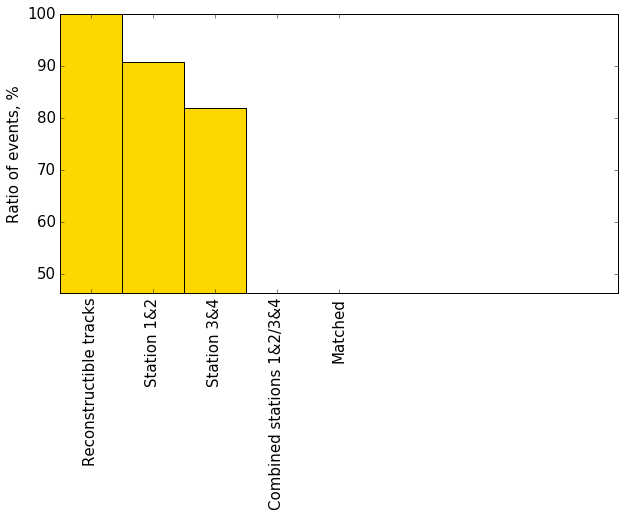

In [21]:
bar_labels = ['Reconstructible tracks', 
              'Station 1&2',
              'Station 3&4',
              'Combined stations 1&2/3&4',
              'Matched']

bar_values = pass_stages.sum(axis=0).values
bar_values = bar_values / bar_values[0] * 100


print bar_values[-1]

x = range(len(bar_labels))
plt.figure(figsize=(10,5))
plt.bar(x, bar_values, width=1., color='gold', align='center')
plt.xticks(x, bar_labels, rotation=90, size=15)
plt.yticks(size=15)
plt.xlim(-0.5, 8.5)
plt.ylim(bar_values[-1], bar_values[0])
plt.ylabel('Ratio of events, %', size=15)
plt.show()

# Momentum

In [22]:
passed_events = event_ids[pass_stages.Matching.values == 1]
p_err = combinations_true[combinations_true.EventID.isin(passed_events)].PErr.values

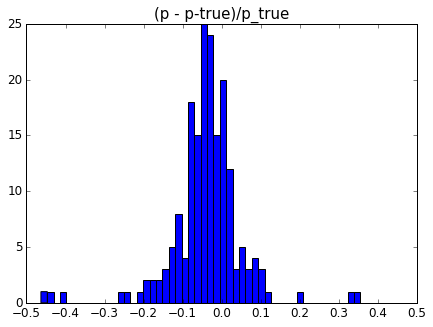

In [23]:
plt.figure(figsize=(7, 5))
plt.hist(p_err, bins=50)

plt.title('(p - p-true)/p_true', size=15)
plt.xticks(numpy.arange(-0.5, 0.51, 0.1), size=12)
plt.yticks(size=12)
plt.xlim(-0.5, 0.5)
plt.show()